In [1]:
!pip install opencv-python

In [2]:
!pip install keras

In [3]:
!pip install tensorflow-gpu

In [34]:
!pip install matplotlib

In [4]:
conda install -c conda-forge google-colab

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
import tensorflow as tf
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
#from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import joblib

In [2]:
tf.test.gpu_device_name()

''

In [3]:
train_path=r'data/glasses_kpi_extraction/traindata/materiau/'
test_path=r'data/glasses_kpi_extraction/testdata/materiau/'
valid_path=r'data/glasses_kpi_extraction/validdata/materiau/'
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [4]:
print(class_names)
print(class_names_test)

['acetate', 'acetate,metal', 'acetate,mixedwood', 'acetate-metal', 'metal', 'plastic', 'plastic-metal']
['acetate', 'acetate,metal', 'acetate,mixedwood', 'acetate-metal', 'metal', 'plastic', 'plastic-metal']


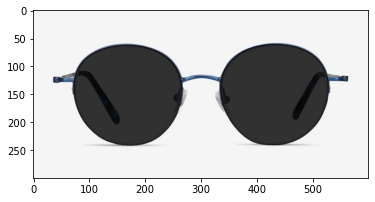

In [5]:
### Sample datasets images
image_argent=cv2.imread('data/glasses_kpi_extraction/traindata/couleur/Bronze/image-31.jpg')
plt.imshow(image_argent)

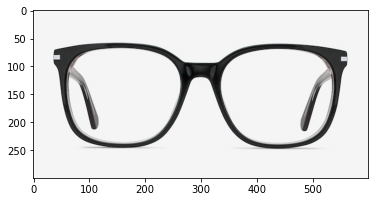

In [6]:
image_noir=cv2.imread('data/glasses_kpi_extraction/traindata/couleur/Noir/image-443.jpg' )
plt.imshow(image_noir)

In [7]:
train_datagen =ImageDataGenerator(preprocessing_function=preprocess_input,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.4)
test_datagen = ImageDataGenerator()

In [8]:
IMAGE_SIZE = (224, 224)

In [9]:
train_generator = train_datagen.flow_from_directory(r'data/glasses_kpi_extraction/traindata/materiau/',target_size=IMAGE_SIZE,batch_size=32,shuffle=True,color_mode="rgb",class_mode='categorical',subset='training')
test_generator = train_datagen.flow_from_directory(r'data/glasses_kpi_extraction/testdata/materiau/',target_size=IMAGE_SIZE,batch_size=32,shuffle=False,color_mode="rgb",class_mode='categorical',subset='validation')
valid_generator=train_datagen.flow_from_directory(r'data/glasses_kpi_extraction/validdata/materiau/',target_size=IMAGE_SIZE,batch_size=32,class_mode ='categorical',subset='validation')


Found 716 images belonging to 7 classes.
Found 102 images belonging to 7 classes.
Found 118 images belonging to 7 classes.


In [10]:
#mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', mode='max', save_best_only=True, verbose=1)

In [11]:
base_model = ResNet50(include_top = False,weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model= Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator,epochs=30)

Epoch 1/30
23/23 [==============================] - 61s 2s/step - loss: 1.5963 - accuracy: 0.5112
Epoch 2/30
23/23 [==============================] - 78s 3s/step - loss: 0.5336 - accuracy: 0.8087
Epoch 3/30
23/23 [==============================] - 85s 4s/step - loss: 0.3428 - accuracy: 0.8897
Epoch 4/30
23/23 [==============================] - 68s 3s/step - loss: 0.2836 - accuracy: 0.9092
Epoch 5/30
23/23 [==============================] - 84s 4s/step - loss: 0.2366 - accuracy: 0.9358
Epoch 6/30
23/23 [==============================] - 66s 3s/step - loss: 0.1849 - accuracy: 0.9483
Epoch 7/30
23/23 [==============================] - 74s 3s/step - loss: 0.1851 - accuracy: 0.9469
Epoch 8/30
23/23 [==============================] - 82s 3s/step - loss: 0.1409 - accuracy: 0.9679
Epoch 9/30
23/23 [==============================] - 88s 4s/step - loss: 0.1587 - accuracy: 0.9553
Epoch 10/30
23/23 [==============================] - 100s 4s/step - loss: 0.0943 - accuracy: 0.9763
Epoch 11/30
23/23 

In [33]:
model.evaluate_generator(test_generator)

<ipython-input-33-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.05710968002676964, 0.9772727489471436]

In [12]:
model.save_weights('Models/materiau/finalized_model.h5')

In [13]:
filename = 'Models/materiau/finalized_model.sav'
joblib.dump(model, filename)

INFO:tensorflow:Assets written to: ram://7648a14e-ad66-4ca8-af3f-d9cd52994d06/assets


INFO:tensorflow:Assets written to: ram://7648a14e-ad66-4ca8-af3f-d9cd52994d06/assets


['Models/materiau/finalized_model.sav']

In [14]:
model_json = model.to_json()
with open(r'Models/materiau/bestmodel.json',"w") as json_file:
  json_file.write(model_json)

### **COLOR PREDICTION**

In [40]:
from keras.models import model_from_json

In [47]:
def predict_(image_path):
    #Load the Model from Json File
    json_file = open(r'Models/materiau/bestmodel.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights(r'Models/materiau/finalized_model.h5')
    #Compile the model
    opt = adam(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if preds==0:
        print("Predicted Label:Cat")
    else:
        print("Predicted Label: Dog")

In [48]:
predict_('data/glasses_kpi_extraction/traindata/couleur/Bronze/image-31.jpg')

NameError: name 'adam' is not defined

In [ ]:
predict_("/content/gdrive/My Drive/datasets/test/Cat/10.jpg")

In [ ]:
predict_("/content/gdrive/My Drive/datasets/test/Cat/7.jpg")